# VLMs writing image analysis code

In this notebook we present images to a VLM and ask it to write image analysis code. One could expect that depending on the image, the VLM suggests different strategies. In a second example, we demonstrate how a list of rules can be used to guide the VLM in using state-of-the-art algorithms depending on image characteristics.

In [1]:
import openai
import PIL
import stackview
from skimage import data
from skimage.io import imread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

We will need some helper functions for assembling a prompt and submitting it to the openai server.

In [2]:
def prompt_with_image(message:str, image=None, model="gpt-4.1-2025-04-14"):
    """A prompt helper function that sends a text message and an image
    to openAI and returns the text response.
    """
    import os
    
    # convert message in the right format if necessary
    if isinstance(message, str):
        message = [{"role": "user", "content": message}]
    
    if image is not None:
        image_message = image_to_message(image)
    else:
        image_message = []
        
    # setup connection to the LLM
    client = openai.OpenAI()
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message + image_message
    )
    
    # extract answer
    return response.choices[0].message.content


def image_to_message(image):
    import base64

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return [{"role": "user", "content": [{
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }

    }]}]


def numpy_to_bytestream(data):
    """Turn a NumPy array into a bytestream"""
    import numpy as np
    from PIL import Image
    import io

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(data.astype(np.uint8)).convert("RGBA")

    # Create a BytesIO object
    bytes_io = io.BytesIO()

    # Save the PIL image to the BytesIO object as a PNG
    image.save(bytes_io, format='PNG')

    # return the beginning of the file as a bytestream
    bytes_io.seek(0)
    return bytes_io.read()

These are the example images we will be using.

[[ 8  8  8 ... 10 11 10]
 [ 8  8  8 ... 11 12 11]
 [ 9  8  7 ... 13 14 14]
 ...
 [ 8  8  8 ...  9  9  9]
 [ 8  8  8 ...  9  8  9]
 [ 9  8  8 ...  9  9  9]]
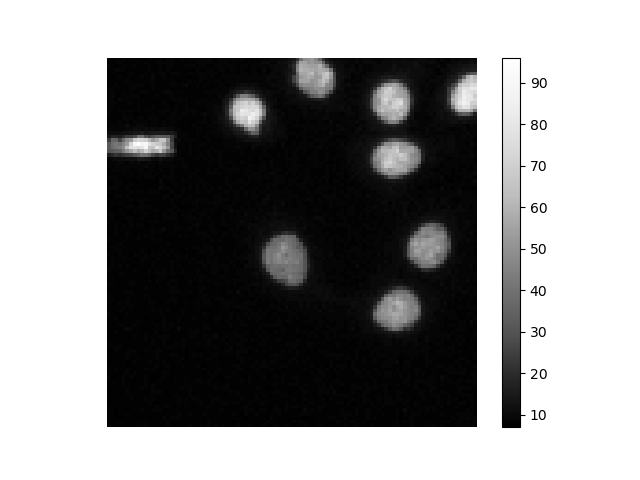
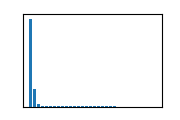

In [3]:
sparse_nuclei_image = data.human_mitosis()[100:200,:100]
stackview.insight(sparse_nuclei_image)

[[14 14 13 ... 15 12 11]
 [17 15 14 ... 16 14 13]
 [22 15 13 ... 16 13 13]
 ...
 [14 14 21 ... 13 13 14]
 [12 12 14 ... 13 14 14]
 [12 11 12 ... 13 14 13]]
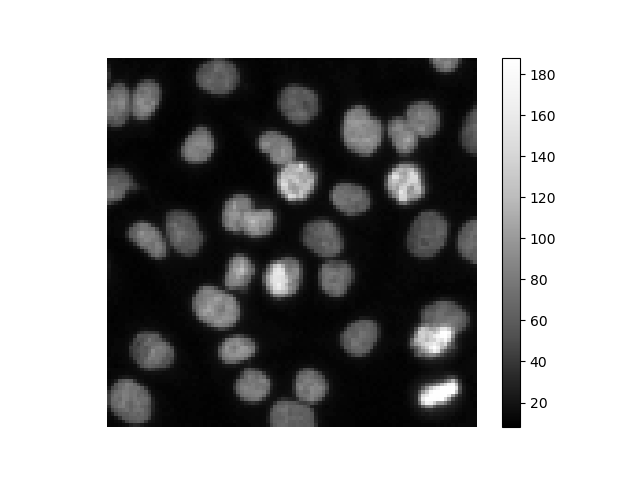
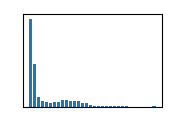

In [4]:
dense_nuclei_image = data.human_mitosis()[330:430, 355:455]
stackview.insight(dense_nuclei_image)

This helper function will send the image together with a prompt to the LLM service provider and display either the code example (if `num_samples=1`) or a box-plot of a selection of found key words / algorithm names in the generated code.

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

def determine_algorithm(prompt, image, num_samples=25):
    responses = []
    for _ in range(num_samples):
        responses.append(prompt_with_image(prompt, image))
    responses = [r.lower().split("```")[1] for r in responses]

    if num_samples == 1:
        print(responses[0])
        return

    # Count occurrences of "watershed" and "stardist"
    counts = Counter()

    counts['threshold'] = 0
    counts['watershed'] = 0
    counts['stardist'] = 0
    counts['cellpose'] = 0
    
    for response in responses:
        if "watershed" in response:
            counts['watershed'] += 1
        if "stardist" in response:
            counts['stardist'] += 1
        if "threshold" in response:
            counts['threshold'] += 1
        if "cellpose" in response:
            counts['cellpose'] += 1

    # Display bar plot
    bars = plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'magenta'])
    plt.ylabel('Number of responses')
    plt.title('Occurrence of algorithm names in code')
    #plt.legend(bars, counts.keys())
    plt.show()

First, we prompt for microscopy image segmentation code using both example images once to see example code that gets generated.

In [6]:
prompt = """You are a bioimage-analysis expert and excellent Python programmer.
First, describe the image in one sentence, then write Python code for segmenting this image. 
"""
determine_algorithm(prompt, sparse_nuclei_image, num_samples=1)

python
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology, exposure

# load image
image = io.imread('path_to_your_image.png')  # replace path as needed

# enhance contrast (optional for weak signals)
image_eq = exposure.equalize_adapthist(image)

# denoise image (optional)
from skimage.restoration import denoise_tv_chambolle
denoised = denoise_tv_chambolle(image_eq, weight=0.1)

# threshold using otsu's method
thresh_val = filters.threshold_otsu(denoised)
binary = denoised > thresh_val

# remove small objects (noise) and fill small holes
cleaned = morphology.remove_small_objects(binary, min_size=30)
cleaned = morphology.binary_closing(cleaned, morphology.disk(2))
cleaned = morphology.binary_fill_holes(cleaned)

# label segmented nuclei
labels = measure.label(cleaned)

# overlay and show results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('original')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.ti

In [7]:
determine_algorithm(prompt, dense_nuclei_image, num_samples=1)

python
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, measure
from skimage.util import img_as_float
from scipy import ndimage as ndi

# load image
image = io.imread('path_to_image.png')  # replace with your file path
image = img_as_float(image)

# smoothing (optional, helps with noise)
from skimage.filters import gaussian
smoothed = gaussian(image, sigma=1.0)

# thresholding
threshold = filters.threshold_otsu(smoothed)
binary = smoothed > threshold

# remove small objects (noise)
cleaned = morphology.remove_small_objects(binary, min_size=30)

# fill holes (optional)
filled = ndi.binary_fill_holes(cleaned)

# label segmented nuclei
labels = measure.label(filled)

# display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('original')
axes[1].imshow(filled, cmap='gray')
axes[1].set_title('segmented mask')
axes[2].imshow(labels, cmap='nipy_spectral')
axes[2].set_title('labeled nuclei')
plt.show()



Then, we run the test multiple times to derive a box-plot of used algorithms.

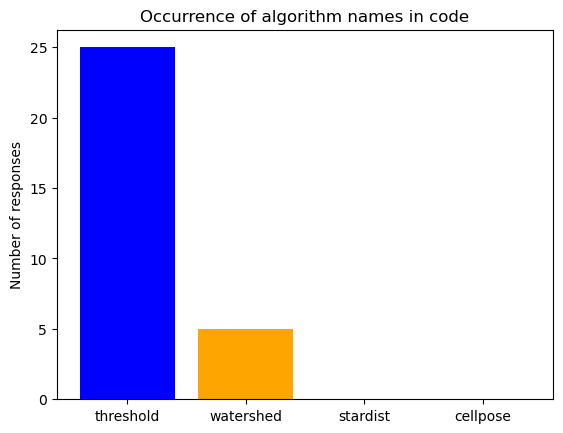

In [8]:
determine_algorithm(prompt, sparse_nuclei_image)

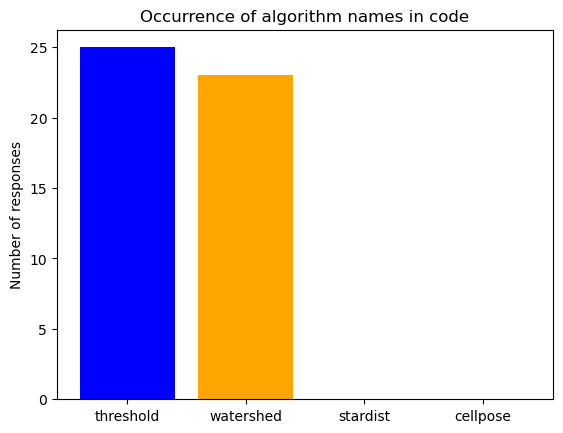

In [9]:
determine_algorithm(prompt, dense_nuclei_image)

Next, we try the same strategy using a more complex prompt containing a list of rules to guide the VLM.

In [10]:
prompt = """You are a bioimage-analysis expert and excellent Python programmer.
First, describe the image in one sentence, then write Python code for segmenting this image according to given rules:
* If an image shows sparse objects such as nuclei, use Otsu-thresholding for segmenting them.
* If an image shows dense, partially overlapping objects such as nuclei, use StarDist.
"""

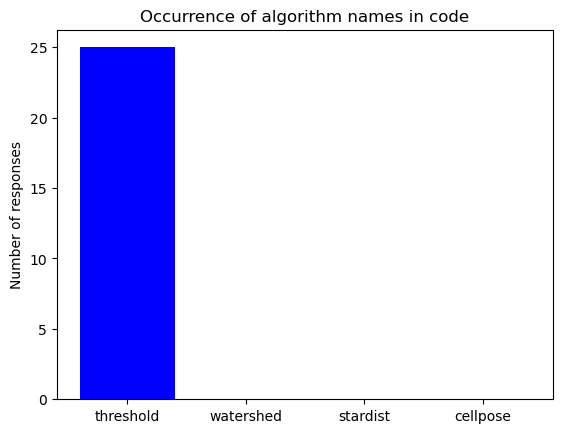

In [11]:
determine_algorithm(prompt, sparse_nuclei_image)

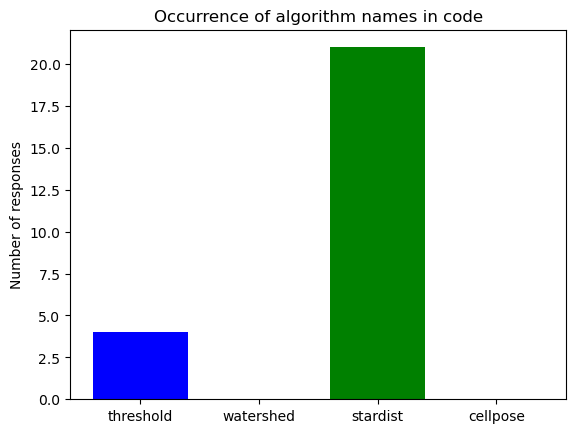

In [12]:
determine_algorithm(prompt, dense_nuclei_image)

For completeness, we display some example code generated with the advanced prompt as well.

In [13]:
determine_algorithm(prompt, sparse_nuclei_image, num_samples=1)

python
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology

# load the image
image = io.imread('your_image_path_here.png')

# apply otsu's threshold
thresh = filters.threshold_otsu(image)
binary = image > thresh

# (optional) clean up small objects and fill holes
cleaned = morphology.remove_small_objects(binary, min_size=20)
cleaned = morphology.remove_small_holes(cleaned, area_threshold=20)

# label the segmented nuclei
labeled = measure.label(cleaned)

# display results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("original image")
axes[1].imshow(cleaned, cmap='gray')
axes[1].set_title("otsu segmentation")
axes[2].imshow(labeled, cmap='nipy_spectral')
axes[2].set_title("labeled nuclei")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()



In [14]:
determine_algorithm(prompt, dense_nuclei_image, num_samples=1)

python
import matplotlib.pyplot as plt
from skimage import io
from stardist.models import stardist2d
from csbdeep.utils import normalize

# load the image
img = io.imread('nuclei.png')  # replace with your image path

# load a pretrained stardist model for nuclei
model = stardist2d.from_pretrained('2d_versatile_fluo')

# normalize the image and predict nuclei masks
labels, _ = model.predict_instances(normalize(img))

# show the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('original')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('stardist segmentation')
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')

plt.tight_layout()
plt.show()

